# Standard MCMC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random

In [2]:
data = pd.read_csv("/Users/brianxiang/Downloads/data.final.2024.Q3.csv")

## Data and Set Up

We are measuring tumor incidence in rats across 15 different experiments. Our data consists of $n_i = $ the number of rats in each experiment $i$ and $y_i = $ the number of those rats that had tumors.

We design a Beta-Binomial hierarchical model as follows:

$$y_i \sim Bin(n_i, \theta_i)$$

$$\theta_i \sim Beta(\alpha, \beta)$$

with noninformative prior $p(\alpha, \beta) \propto 1$.

This gives us the following conditional distributions:

$$\theta_i | y_i, \alpha, \beta \sim Beta(y_i + \alpha, n_i - y_i + \beta)$$

$$p(\alpha, \beta | y, \theta) \propto (\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)})^{15}\prod_{i = 1}^{15}\theta_i^\alpha(1 - \theta_i)^\beta \Rightarrow$$

$$\ln(p(\alpha, \beta | y, \theta)) \propto -15\ln(\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}) + \sum_{i = 1}^{15} \alpha \ln(\theta_i) + \beta \ln(1 - \theta_i)$$

We use a Gibbs sampler with a Metropolis step to sample from the joint posterior distribution $\theta, \alpha, \beta | y$ using normal proposal distributions $\alpha^* \sim Norm(\alpha^{t - 1}. \nu_\alpha), \beta^* \sim Norm(\beta^{t - 1}. \nu_\beta)$ for each iteration $t$ with tuning parameter $\nu_\alpha, \nu_\beta$.



In [454]:
def logab(theta, a, b):
    if a <= 0 or b <= 0:
        return -float("inf")
    return -15 * np.log(scipy.special.beta(a, b)) + np.sum(a * np.log(theta) + b * np.log(1 - theta))

In [455]:
def chain(n, y, theta_init, alpha_init, beta_init, numsamp, atuning = 0.3, btuning = 1.1):
    accept = 0
    reject = 0
    
    theta_samps = np.zeros((numsamp, 15))
    alpha_samps = np.zeros(numsamp)
    beta_samps = np.zeros(numsamp)
    
    theta_samps[0] = theta_init
    alpha_samps[0] = alpha_init
    beta_samps[0] = beta_init
    
    for i in range(1, numsamp):        
        alpha_prop = np.random.normal(alpha_samps[i - 1], atuning)
        beta_prop = np.random.normal(beta_samps[i - 1], btuning)
        log_r = logab(theta_samps[i - 1], alpha_prop, beta_prop) - logab(theta_samps[i - 1], alpha_samps[i - 1], beta_samps[i - 1])
        log_u = np.log(random.uniform(0, 1))
        
        if log_u <= log_r:
            alpha_samps[i] = alpha_prop
            beta_samps[i] = beta_prop
            accept = accept + 1
            
        else:
            alpha_samps[i] = alpha_samps[i - 1]
            beta_samps[i] = beta_samps[i - 1]
            reject = reject + 1
            
        theta_samps[i] = np.random.beta(y + alpha_samps[i], n - y + beta_samps[i], 15)
        
    print("Acceptance Rate: ", accept/(accept + reject))
    
    return theta_samps, alpha_samps, beta_samps


## Initial Values and Tuning Parameters

We use two chain with inital values:

$$\alpha_1^{(0)} = 1, \beta_1^{(0)} = 2, \theta_{1i}^{(0)} \sim Beta(y_i + 1, n_i - y_i + 2)$$

and 

$$\alpha_2^{(0)} = 20, \beta_2^{(0)} = 50, \theta_{2i}^{(0)} \sim Beta(y_i + 20, n_i - y_i + 50)$$

We use tuning parameters $\nu_\alpha = 0.3, \nu_\beta = 1.1$ which were determined based on the acceptance rate ($\sim$75%).

In [472]:
n = data['n'].to_numpy()
y = data['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

theta_samps1, alpha_samps1, beta_samps1 = chain(n, y, theta_1, a_1, b_1, 2000)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps2, alpha_samps2, beta_samps2 = chain(n, y, theta_2, a_2, b_2, 2000)

Acceptance Rate:  0.7408704352176088
Acceptance Rate:  0.7718859429714857


In [473]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 2000, 2000), alpha_samps1, beta_samps1, theta_samps1.T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 2000, 2000), alpha_samps2, beta_samps2, theta_samps2.T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))

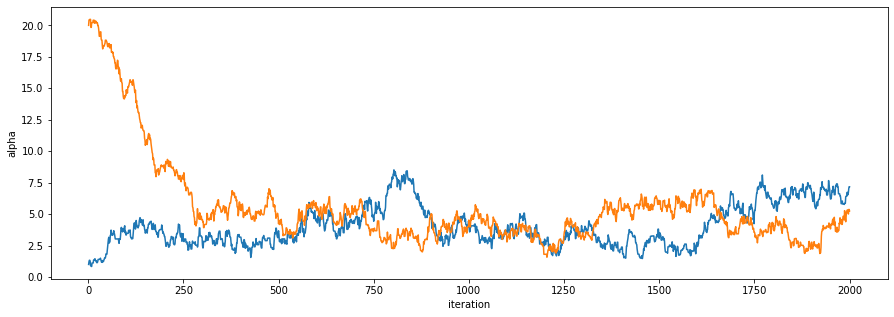

In [474]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

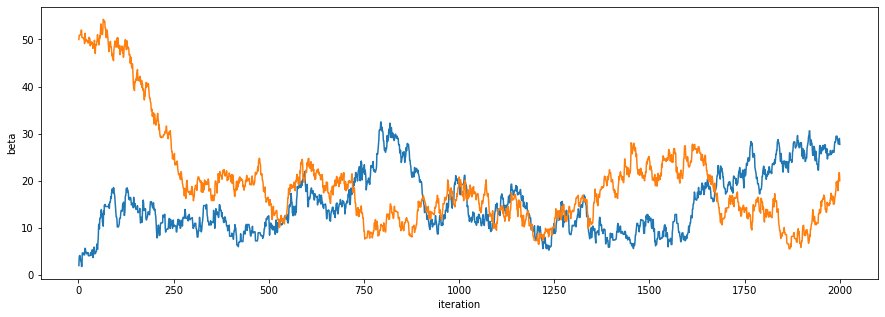

In [475]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

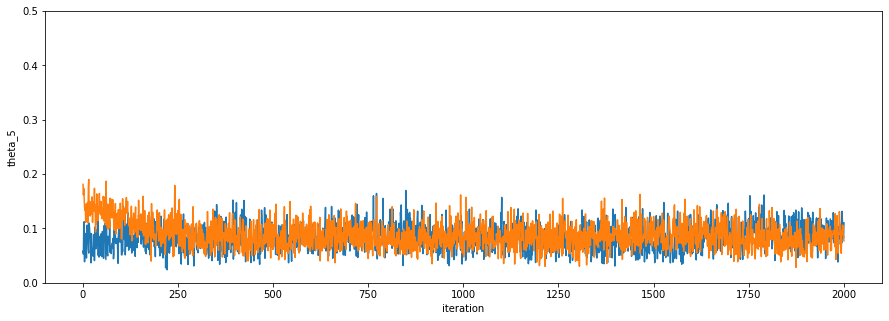

In [476]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

ax.set_ylim(0, 0.5)
plt.show()

# Unbiased MCMC

In [3]:
# def sample_alpha(asamp, bsamp, tsamp, tuning):
#     alpha_prop = np.random.normal(asamp, tuning)
#     log_r = loga(alpha_prop, bsamp, tsamp) - logab(asamp, bsamp, tsamp)
#     log_u = np.log(random.uniform(0, 1))

#     if log_u <= log_r:
#         return alpha_prop
#     else:
#         return asamp

In [4]:
# def sample_beta(asamp, bsamp, tsamp, tuning):
#     beta_prop = np.random.normal(bsamp, tuning)
#     log_r = logb(asamp, beta_prop, tsamp) - logab(asamp, bsamp, tsamp)
#     log_u = np.log(random.uniform(0, 1))

#     if log_u <= log_r:
#         return beta_prop
#     else:
#         return bsamp

In [5]:
def loga(alpha, beta, theta):
    if alpha <= 0:
        return -float("inf")
    return 15 * (np.log(scipy.special.gamma(alpha + beta)) - np.log(scipy.special.gamma(alpha))) + alpha * np.sum(np.log(theta))

In [6]:
def logb(alpha, beta, theta):
    if beta <= 0:
        return -float("inf")
    return 15 * (np.log(scipy.special.gamma(alpha + beta)) - np.log(scipy.special.gamma(beta))) + beta * np.sum(np.log(1 - theta))

In [46]:
def sample_couple(x, samp_func, p, q):
    wx = random.uniform(0, p(x))
    if wx <= q(x):
        return x, 1
    else:
        y_star = samp_func()
        wy = random.uniform(0, q(y_star))
        
        while wy <= p(y_star):
            y_star = samp_func()
            wy = random.uniform(0, q(y_star))
            
        return y_star, 0

In [8]:
def coupled_metropolis(n, y, theta_init1, alpha_init1, beta_init1, theta_init2, alpha_init2, beta_init2, numsamp, atuning = 0.3, btuning = 1.1, lag = 1):
    theta_samps1 = np.zeros((numsamp, 15))
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    
    theta_samps2 = np.zeros((numsamp - lag, 15))
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    
    theta_samps1[0] = theta_init1
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    
    theta_samps2[0] = theta_init2
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
        
    for i in range(1, numsamp):
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], atuning)
        log_ua1 = np.log(random.uniform(0, 1))
        log_ra1 = loga(alpha_prop1, beta_samps1[i - 1], theta_samps1[i - 1]) - loga(alpha_samps1[i - 1], beta_samps1[i - 1], theta_samps1[i - 1])

        if log_ua1 <= log_ra1:
            alpha_samps1[i] = alpha_prop1            
        else:
            alpha_samps1[i] = alpha_samps1[i - 1]
            
        beta_prop1 = np.random.normal(beta_samps1[i - 1], btuning)
        log_ub1 = np.log(random.uniform(0, 1))
        log_rb1 = logb(alpha_samps1[i], beta_prop1, theta_samps1[i - 1]) - logb(alpha_samps1[i], beta_samps1[i - 1], theta_samps1[i - 1])
        
        if log_ub1 <= log_rb1:
            beta_samps1[i] = beta_prop1
        else:
            beta_samps1[i] = beta_samps1[i - 1]
            
        theta_prop1 = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)
        theta_samps1[i] = theta_prop1
            
        if lag < i:
            alpha_prop2 = sample_couple(alpha_prop1, 
                                        lambda : np.random.normal(alpha_samps2[i - lag - 1], atuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, alpha_samps1[i - 1], atuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, alpha_samps2[i - lag - 1], atuning)
                                        )
            log_ua2 = np.log(random.uniform(0, 1))
            log_ra2 = loga(alpha_prop2, beta_samps2[i - lag - 1], theta_samps2[i - lag - 1]) - loga(alpha_samps2[i - lag - 1], beta_samps2[i - lag - 1], theta_samps2[i - lag - 1])
            
            if log_ua2 <= log_ra2:
                alpha_samps2[i - lag] = alpha_prop2
            else:
                alpha_samps2[i - lag] = alpha_samps2[i - lag - 1]

            beta_prop2 = sample_couple(beta_prop1, 
                                        lambda : np.random.normal(beta_samps2[i - lag - 1], btuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, beta_samps1[i - 1], btuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, beta_samps2[i - lag - 1], btuning)
                                        )
            log_ub2 = np.log(random.uniform(0, 1))
            log_rb2 = logb(alpha_samps2[i - lag], beta_prop2, theta_samps2[i - lag - 1]) - logb(alpha_samps2[i - lag], beta_samps2[i - lag - 1], theta_samps2[i - lag - 1])
            
            if log_ub2 <= log_rb2:
                beta_samps2[i - lag] = beta_prop2
            else:
                beta_samps2[i - lag] = beta_samps2[i - lag - 1]
                                   
            theta_prop2 = np.zeros(len(theta_prop1))
            for j in range(len(theta_prop1)):
                theta_prop2[j] = sample_couple(theta_prop1[j],
                                            lambda : np.random.beta(y[j] + alpha_samps2[i - lag], n[j] - y[j] + beta_samps2[i - lag]),
                                            lambda x1: scipy.stats.beta.pdf(x1, y[j] + alpha_samps1[i], n[j] - y[j] + beta_samps1[i]),
                                            lambda x2: scipy.stats.beta.pdf(x2, y[j] + alpha_samps2[i - lag], n[j] - y[j] + beta_samps2[i - lag])
                                            )
                
            theta_samps2[i - lag] = theta_prop2

    return theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2


In [9]:
n = data['n'].to_numpy()
y = data['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2 = coupled_metropolis(n, y, theta_1, a_1, b_1, theta_2, a_2, b_2, 2000)

In [478]:
# def coupled_metropolis3(n, y, theta_init1, alpha_init1, beta_init1, theta_init2, alpha_init2, beta_init2, numsamp, atuning = 0.3, btuning = 1.1, lag = 1):
#     theta_samps1 = np.zeros((numsamp, 15))
#     alpha_samps1 = np.zeros(numsamp)
#     beta_samps1 = np.zeros(numsamp)
    
#     theta_samps2 = np.zeros((numsamp - lag, 15))
#     alpha_samps2 = np.zeros(numsamp - lag)
#     beta_samps2 = np.zeros(numsamp - lag)
    
#     theta_samps1[0] = theta_init1
#     alpha_samps1[0] = alpha_init1
#     beta_samps1[0] = beta_init1
    
#     theta_samps2[0] = theta_init2
#     alpha_samps2[0] = alpha_init2
#     beta_samps2[0] = beta_init2
    
#     for i in range(1, numsamp):
#         if i <= lag:
#             alpha_prop1 = np.random.normal(alpha_samps1[i - 1], atuning)
#             log_ua1 = np.log(random.uniform(0, 1))
#             log_ra1 = loga(alpha_prop1, beta_samps1[i - 1], theta_samps1[i - 1]) - loga(alpha_samps1[i - 1], beta_samps1[i - 1], theta_samps1[i - 1])
                 
#             if log_ua1 <= log_ra1:
#                 alpha_samps1[i] = alpha_prop1
#             else:
#                 alpha_samps1[i] = alpha_samps1[i - 1]
            
#             beta_prop1 = np.random.normal(beta_samps1[i - 1], btuning)
#             log_ub1 = np.log(random.uniform(0, 1))
#             log_rb1 = logb(alpha_samps1[i], beta_prop1, theta_samps1[i - 1]) - logb(alpha_samps1[i], beta_samps1[i - 1], theta_samps1[i - 1])
            
#             if log_ub1 <= log_rb1:
#                 beta_samps1[i] = beta_prop1
                
#             else:
#                 beta_samps1[i] = beta_samps1[i - 1]
                
#             theta_samps1[i] = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)
            
#         else:
#             alpha_prop1 = np.random.normal(alpha_samps1[i - 1], atuning)
#             wxa = random.uniform(0, scipy.stats.norm.pdf(alpha_prop1, alpha_samps1[i - 1], atuning))
            
#             if wxa <= scipy.stats.norm.pdf(alpha_prop1, alpha_samps2[i - lag - 1], atuning):
#                 alpha_prop2 = alpha_prop1
                
#             else:
#                 alpha_prop2 = np.random.normal(alpha_samps2[i - lag - 1], atuning)
#                 wya = random.uniform(0, scipy.stats.norm.pdf(alpha_prop2, alpha_samps2[i - lag - 1], atuning))

#                 while(wya <= scipy.stats.norm.pdf(alpha_prop2, alpha_samps1[i - 1], atuning)):
#                     alpha_prop2 = np.random.normal(alpha_samps2[i - lag - 1], atuning)
#                     wya = random.uniform(0, scipy.stats.norm.pdf(alpha_prop2, alpha_samps2[i - lag - 1], atuning))

#             log_ua1 = np.log(random.uniform(0, 1))
#             log_ra1 = loga(alpha_prop1, beta_samps1[i - 1], theta_samps1[i - 1]) - loga(alpha_samps1[i - 1], beta_samps1[i - 1], theta_samps1[i - 1])
            
#             if log_ua1 <= log_ra1:
#                 alpha_samps1[i] = alpha_prop1
#             else:
#                 alpha_samps1[i] = alpha_samps1[i - 1]
            
#             log_ua2 = np.log(random.uniform(0, 1))
#             log_ra2 = loga(alpha_prop2, beta_samps2[i - lag - 1], theta_samps2[i - lag - 1]) - loga(alpha_samps2[i - lag - 1], beta_samps2[i - lag - 1], theta_samps2[i - lag - 1])
            
#             if log_ua2 <= log_ra2:
#                 alpha_samps2[i - lag] = alpha_prop2                
#             else:
#                 alpha_samps2[i - lag] = alpha_samps2[i - lag - 1]                
                
#             beta_prop1 = np.random.normal(beta_samps1[i - 1], btuning)
#             wxb = random.uniform(0, scipy.stats.norm.pdf(beta_prop1, beta_samps1[i - 1], btuning))

            
#             if wxb <= scipy.stats.norm.pdf(beta_prop1, beta_samps2[i - lag - 1], btuning):
#                 beta_prop2 = beta_prop1
#             else:
#                 beta_prop2 = np.random.normal(beta_samps2[i - lag - 1], btuning)
#                 wyb = random.uniform(0, scipy.stats.norm.pdf(beta_prop2, beta_samps2[i - lag - 1], btuning))
                
#                 while(wyb <= scipy.stats.norm.pdf(beta_prop2, beta_samps1[i - 1], btuning)):
#                     beta_prop2 = np.random.normal(beta_samps2[i - lag - 1], btuning)
#                     wyb = random.uniform(0, scipy.stats.norm.pdf(beta_prop2, beta_samps2[i - lag - 1], btuning))
                
#             log_ub1 = np.log(random.uniform(0, 1))
#             log_rb1 = logb(alpha_samps1[i], beta_prop1, theta_samps1[i - 1]) - logb(alpha_samps1[i], beta_samps1[i - 1], theta_samps1[i - 1])
            
#             if log_ub1 <= log_rb1:
#                 beta_samps1[i] = beta_prop1
#             else:
#                 beta_samps1[i] = beta_samps1[i - 1]
                
#             log_ub2 = np.log(random.uniform(0, 1))
#             log_rb2 = logb(alpha_samps2[i - lag], beta_prop2, theta_samps2[i - lag - 1]) - logb(alpha_samps2[i - lag], beta_samps2[i - lag - 1], theta_samps2[i - lag - 1])
            
#             if log_ub2 <= log_rb2:
#                 beta_samps2[i - lag] = beta_prop2
#             else:
#                 beta_samps2[i - lag] = beta_samps2[i - lag - 1]
            
#             theta_samps1[i] = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)
            
#             theta_prop2 = np.zeros(len(theta_samps1[i]))
            
#             for j in range(len(theta_samps1[i])):
#                 wxt = random.uniform(0, scipy.stats.beta.pdf(theta_samps1[i, j], alpha_samps1[i] + y[j], beta_samps1[i] + n[j] - y[j]))
                
#                 if wxt <= scipy.stats.beta.pdf(theta_samps1[i, j], alpha_samps2[i - lag] + y[j], beta_samps1[i - lag] + n[j] - y[j]):
#                     theta_prop2[j] = theta_samps1[i, j]
                    
#                 else:
#                     theta_prop2[j] = np.random.beta(y[j] + alpha_samps2[i - lag], n[j] - y[j] + beta_samps2[i - lag])
#                     wyt = random.uniform(0, scipy.stats.beta.pdf(theta_prop2[j], alpha_samps2[i - lag] + y[j], beta_samps1[i - lag] + n[j] - y[j]))
                    
#                     while wyt <= scipy.stats.beta.pdf(theta_prop2[j], y[j] + alpha_samps1[i], n[j] - y[j] + beta_samps1[i]):
#                         theta_prop2[j] = np.random.beta(y[j] + alpha_samps2[i - lag], n[j] - y[j] + beta_samps2[i - lag])
#                         wyt = random.uniform(0, scipy.stats.beta.pdf(theta_prop2[j], alpha_samps2[i - lag] + y[j], beta_samps1[i - lag] + n[j] - y[j]))
                    
#             theta_samps2[i - lag] = theta_prop2
            
#     return theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2


## Current Working Version with Automatic Convergence Detection

In [56]:
def unbiased_metropolis(n, y, theta_init1, alpha_init1, beta_init1, theta_init2, alpha_init2, beta_init2, numsamp, atuning = 0.3, btuning = 1.1, lag = 1):
    theta_samps1 = np.zeros((numsamp, 15))
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    
    theta_samps2 = np.zeros((numsamp - lag, 15))
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    
    theta_samps1[0] = theta_init1
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    
    theta_samps2[0] = theta_init2
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    
    cnta = 0
    cntb = 0
    cnttheta = np.zeros(15)
    
    converge = False
        
    for i in range(1, numsamp):
        if cnta > 20 and cntb > 20 and all(cnttheta > 20):
            if not converge:
                print(i)
                converge = True
            
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], atuning)
        log_ua1 = np.log(random.uniform(0, 1))
        log_ra1 = loga(alpha_prop1, beta_samps1[i - 1], theta_samps1[i - 1]) - loga(alpha_samps1[i - 1], beta_samps1[i - 1], theta_samps1[i - 1])

        if log_ua1 <= log_ra1:
            alpha_samps1[i] = alpha_prop1            
        else:
            alpha_samps1[i] = alpha_samps1[i - 1]
            
        beta_prop1 = np.random.normal(beta_samps1[i - 1], btuning)
        log_ub1 = np.log(random.uniform(0, 1))
        log_rb1 = logb(alpha_samps1[i], beta_prop1, theta_samps1[i - 1]) - logb(alpha_samps1[i], beta_samps1[i - 1], theta_samps1[i - 1])
        
        if log_ub1 <= log_rb1:
            beta_samps1[i] = beta_prop1
        else:
            beta_samps1[i] = beta_samps1[i - 1]
            
        theta_prop1 = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)
        theta_samps1[i] = theta_prop1
            
        if lag < i:
            alpha_prop2, aind = sample_couple(alpha_prop1, 
                                        lambda : np.random.normal(alpha_samps2[i - lag - 1], atuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, alpha_samps1[i - 1], atuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, alpha_samps2[i - lag - 1], atuning)
                                        )
            log_ua2 = np.log(random.uniform(0, 1))
            log_ra2 = loga(alpha_prop2, beta_samps2[i - lag - 1], theta_samps2[i - lag - 1]) - loga(alpha_samps2[i - lag - 1], beta_samps2[i - lag - 1], theta_samps2[i - lag - 1])
            
            if log_ua2 <= log_ra2:
                alpha_samps2[i - lag] = alpha_prop2
            else:
                alpha_samps2[i - lag] = alpha_samps2[i - lag - 1]
                
            if aind == 0:
                cnta = 0
            else:
                cnta += aind

            beta_prop2, bind = sample_couple(beta_prop1, 
                                        lambda : np.random.normal(beta_samps2[i - lag - 1], btuning),
                                        lambda x1: scipy.stats.norm.pdf(x1, beta_samps1[i - 1], btuning),
                                        lambda x2: scipy.stats.norm.pdf(x2, beta_samps2[i - lag - 1], btuning)
                                        )
            log_ub2 = np.log(random.uniform(0, 1))
            log_rb2 = logb(alpha_samps2[i - lag], beta_prop2, theta_samps2[i - lag - 1]) - logb(alpha_samps2[i - lag], beta_samps2[i - lag - 1], theta_samps2[i - lag - 1])
            
            if log_ub2 <= log_rb2:
                beta_samps2[i - lag] = beta_prop2
            else:
                beta_samps2[i - lag] = beta_samps2[i - lag - 1]
                
            if bind == 0:
                cntb = 0
            else:
                cntb += bind
                                   
            theta_prop2 = np.zeros(len(theta_prop1))
            for j in range(len(theta_prop1)):
                
                theta_prop2[j], tind = sample_couple(theta_prop1[j],
                                            lambda : np.random.beta(y[j] + alpha_samps2[i - lag], n[j] - y[j] + beta_samps2[i - lag]),
                                            lambda x1: scipy.stats.beta.pdf(x1, y[j] + alpha_samps1[i], n[j] - y[j] + beta_samps1[i]),
                                            lambda x2: scipy.stats.beta.pdf(x2, y[j] + alpha_samps2[i - lag], n[j] - y[j] + beta_samps2[i - lag])
                                            )
                
                if tind == 0:
                    cnttheta[j] = 0
                else:
                    cnttheta[j] += tind
                
            theta_samps2[i - lag] = theta_prop2
        
        
    if not converge:
        print("did not converge")
        
    return theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2


In [57]:
n = data['n'].to_numpy()
y = data['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2 = unbiased_metropolis(n, y, theta_1, a_1, b_1, theta_2, a_2, b_2, 15000)

1581


In [62]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps1[1:10001], beta_samps1[1:10001], theta_samps1[1:10001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps2[:10000], beta_samps2[:10000], theta_samps2[:10000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))

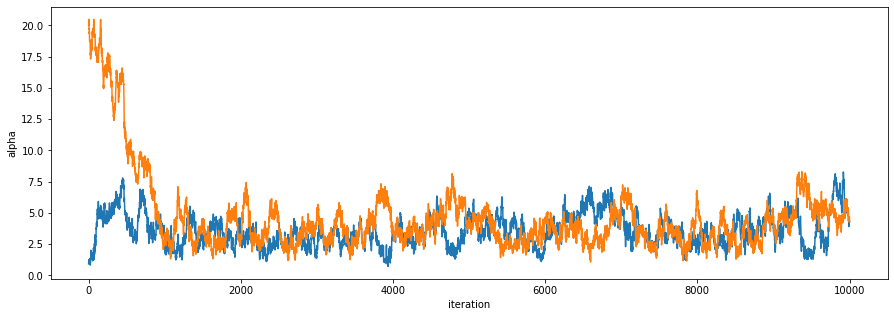

In [63]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

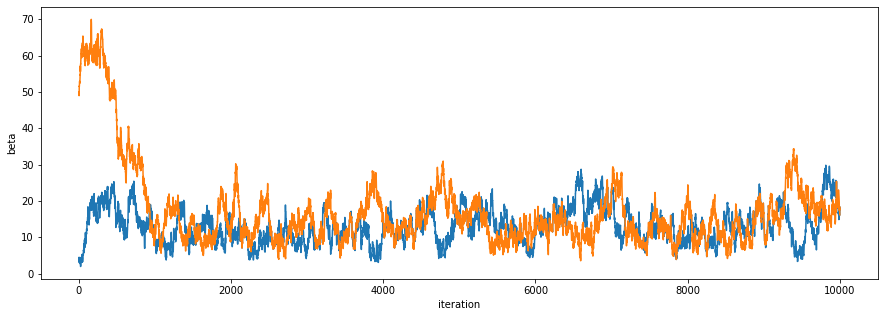

In [64]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

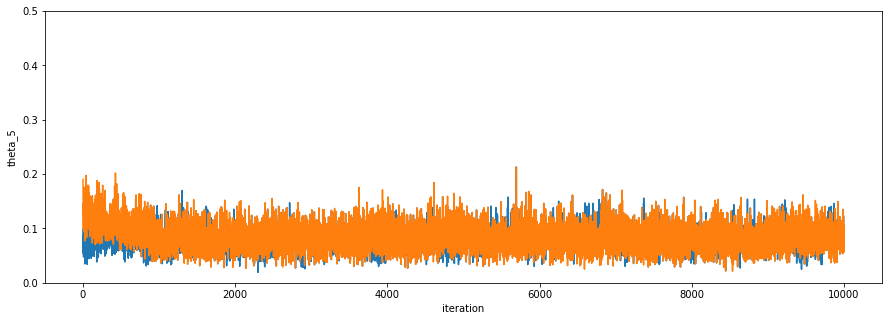

In [61]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

ax.set_ylim(0, 0.5)
plt.show()